In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


#Limit GPU memory usage
using_gpu_index = 0
gpu_list = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_list) > 0:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpu_list[using_gpu_index], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)
else:
    print("Got no GPUs")


d:\PythonENV\p38tf25\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Logistic Regression and Dempster-Shafer

In [2]:
# load Heart Disease data
data = pd.read_csv("https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data", index_col=0)
data_new = data[['ldl','age','chd']]
X_train = data_new.values[:300,:2]
Y_train = data_new.values[:300,[2]]
X_test = data_new.values[300:,:2]
Y_test = data_new.values[300:,[2]]

In [3]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression model
model = LogisticRegression()
model.fit(X_train,Y_train)
model.score(X_test,Y_test)

d:\PythonENV\p38tf25\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7469135802469136

In [4]:
# Model parameters
w = model.coef_[0]                                
b = model.intercept_
print(w)
print(b)

[0.14177157 0.05555956]
[-3.70800497]


## Solve for alpha

In [5]:
b1 = w[0]
b2 = w[1]
b0 = b[0]
u1 = np.mean(X_train[:,0] * b1)
u2 = np.mean(X_train[:,1] * b2)
a1 = b0/2 + 1/2*(b1*u1+b2*u2) - b1*u1
a2 = b0/2 + 1/2*(b1*u1+b2*u2) - b2*u2

## Obtain mass

In [6]:
# w+ and w-
base = np.zeros((len(X_test),1))
w_plus = np.max(np.concatenate((X_test[:,[0]]*b1+a1,base),axis=1),1) + np.max(np.concatenate((X_test[:,[1]]*b2+a2,base),axis=1),1)
w_minus = np.max(np.concatenate((-(X_test[:,[0]]*b1+a1),base),axis=1),1) + np.max(np.concatenate((-(X_test[:,[1]]*b2+a2),base),axis=1),1)
# mass function
conflict = 1-(1-np.exp(-1*w_plus))*(1-np.exp(-1*w_minus))
m1 = (1-np.exp(-1*w_plus))*np.exp(-1*w_minus)/conflict
m2 = (1-np.exp(-1*w_minus))*np.exp(-1*w_plus)/conflict
m0 = np.exp(-1*w_plus)*np.exp(-1*w_minus)/conflict
m1 = m1.reshape(-1,1)
m2 = m2.reshape(-1,1)
m0 = m0.reshape(-1,1)
m = np.concatenate((m2,m1,m0),axis=1)

## Decision based on ID rules

In [7]:
R_upper_lower = []
results = []
for i in range(len(X_test)):
    upper1 = 1-m[i][0]
    lower1 = 1-m[i][0]-m[i][2]
    upper2 = 1-m[i][1]
    lower2 = 1-m[i][1]-m[i][2]
    if lower2>upper1:
        results.append(0)
    elif lower1>upper2:
        results.append(1)
    else:
        results.append(2)
    R_upper_lower.append([[lower1,upper1],[lower2,upper2]])


## Observe the difference in accuracy between the probabilistic decision-making results obtained based on likelihood and the direct decision-making results of the logistic regression model

In [8]:
p1=(m[:,1]+m[:,2])/((m[:,1]+m[:,2])+(m[:,0]+m[:,2]))
predict = np.where(p1>0.5,1,0)
np.mean(predict == Y_test.squeeze())

0.7469135802469136

## Confusion matrix

In [9]:
confusion_matrix = np.zeros((3,2))
for i in range(len(X_test)):
    pred = int(results[i])
    true = int(Y_test[i][0])
    confusion_matrix[pred,true] = confusion_matrix[pred,true]+1

In [10]:
confusion_matrix = confusion_matrix/np.sum(confusion_matrix)
confusion_matrix

array([[0.47530864, 0.07407407],
       [0.06790123, 0.08641975],
       [0.14814815, 0.14814815]])

# Neural Networks and Dempster-Shafer Theory

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# Generate Gaussian Multi-category Data
# Generate unit matrix
I = np.zeros((2,2))
for i in range(2):
    I[i,i]=1
# Mean
mean1 = mean2 = [0.0,0.0]
mean3 = [1,-1]
# Covariance matrix
sigma1 = 0.1*I
sigma2 = 0.5*I
sigma3 = [[0.3,-0.15],[-0.15,0.3]]

mean = {0:mean1,1:mean2,2:mean3}
sigma = {0:sigma1,1:sigma2,2:sigma3}

# Generate Gaussian Multi-category Training Data
for i in range(3):
    if i ==0:
        datai = np.random.multivariate_normal(mean=mean[i], cov=sigma[i], size=300)
        label = np.zeros((300,1))+i
        datai = np.concatenate((datai,label),-1)
        data = datai
    else:
        datai = np.random.multivariate_normal(mean=mean[i], cov=sigma[i], size=300)
        label = np.zeros((300,1))+i
        datai = np.concatenate((datai,label),-1)
        data = np.concatenate((data,datai))
from sklearn.utils import shuffle
data = shuffle(data,random_state=1999)
data = shuffle(data,random_state=2005)
data = shuffle(data,random_state=2015)
data = shuffle(data,random_state=2018)
data = shuffle(data,random_state=2022)

# Generate Gaussian Multi-category Testing Data
for i in range(3):
    if i ==0:
        datai = np.random.multivariate_normal(mean=mean[i], cov=sigma[i], size=200)
        label = np.zeros((200,1))+i
        datai = np.concatenate((datai,label),-1)
        data_test = datai
    else:
        datai = np.random.multivariate_normal(mean=mean[i], cov=sigma[i], size=200)
        label = np.zeros((200,1))+i
        datai = np.concatenate((datai,label),-1)
        data_test = np.concatenate((data_test,datai))

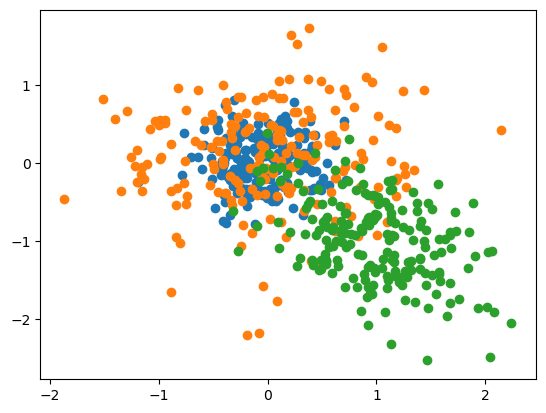

In [12]:
import matplotlib.pyplot as plt
for i in range(3):
    datai = data_test[data_test[:,2]==i]
    plt.scatter(datai[:,0],datai[:,1])

## Data set division and Model training

In [13]:
train_data = data[:int(0.7*len(data))]
val_data = data[int(0.7*len(data)):]
def Decision_model():
    inputs = tf.keras.layers.Input(shape=(2),name = 'd0')
    x1 = tf.keras.layers.Dense(units=20,activation='relu',
                                   name = 'd1')(inputs)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    x1 = tf.keras.layers.Dense(units=10,activation='relu',
                                   name = 'd2')(x1)
    outputs = tf.keras.layers.Dense(units=3,activation='softmax',
                                   name = 'd3')(x1)
    #模型在后面训练、使用
    model_train = keras.Model(inputs = inputs, outputs = outputs,name = "multi-cate")
    return model_train
Decision = Decision_model()
####################################################模型编译&计算####################################################################

Decision.compile(keras.optimizers.Adam(lr = 0.001),metrics=['acc'],loss=tf.keras.losses.SparseCategoricalCrossentropy())

history_D = Decision.fit(train_data[:,:2],train_data[:,2],validation_data=(val_data[:,:2],val_data[:,2]),epochs=500,batch_size=120)

d:\PythonENV\p38tf25\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500
6/6 [==============================] - 1s 19ms/step - loss: 1.1991 - acc: 0.3159 - val_loss: 1.1420 - val_acc: 0.2741
Epoch 2/500
6/6 [==============================] - 0s 4ms/step - loss: 1.1837 - acc: 0.3143 - val_loss: 1.1199 - val_acc: 0.2704
Epoch 3/500
6/6 [==============================] - 0s 4ms/step - loss: 1.1626 - acc: 0.2746 - val_loss: 1.1014 - val_acc: 0.2593
Epoch 4/500
6/6 [==============================] - 0s 4ms/step - loss: 1.1437 - acc: 0.2984 - val_loss: 1.0864 - val_acc: 0.2148
Epoch 5/500
6/6 [==============================] - 0s 4ms/step - loss: 1.1175 - acc: 0.2730 - val_loss: 1.0743 - val_acc: 0.2000
Epoch 6/500
6/6 [==============================] - 0s 4ms/step - loss: 1.1112 - acc: 0.2810 - val_loss: 1.0629 - val_acc: 0.2926
Epoch 7/500
6/6 [==============================] - 0s 4ms/step - loss: 1.0960 - acc: 0.2794 - val_loss: 1.0520 - val_acc: 0.4778
Epoch 8/500
6/6 [==============================] - 0s 4ms/step - loss: 1.0699 - acc: 0.3444 - va

In [14]:
beta_set = (Decision.variables[4]).numpy()
beta_set

array([[-0.7352078 ,  0.5931659 , -0.75154734],
       [-0.699453  ,  1.1146278 ,  0.2949298 ],
       [ 0.16172773, -0.7675157 ,  0.13551141],
       [-0.6960918 , -0.79622525,  0.10581598],
       [-0.1235126 , -0.38630882,  0.9311485 ],
       [-0.21070063, -0.49759236,  0.95861465],
       [-1.2269756 , -0.01212703,  0.31633127],
       [-0.45387587, -0.31037644,  0.92670286],
       [ 0.11030975,  0.45583838, -0.76999855],
       [ 0.72775537, -0.48554283, -0.46468857]], dtype=float32)

In [15]:
bias_set = (Decision.variables[5]).numpy()
bias_set

array([ 0.37613076, -0.17900391, -0.2435637 ], dtype=float32)

## Intercept the model whose output is ten features, calculate u, and calculate alpha

In [16]:
truncated_model = tf.keras.Model(inputs = Decision.input, outputs = Decision.get_layer('d2').output)

In [17]:
fai_j = truncated_model.predict(train_data[:,:2])
nu_j = np.mean(fai_j,0)
sum_betajk_nu = []
# calcuate nu
for i in range(3):
    sum_i = np.sum(beta_set[:,i]*nu_j)
    sum_betajk_nu.append(sum_i)
alpha = np.zeros_like(beta_set)
# calculate alpha
for i in range(3):
    for j in range(10):
        alpha[j,i] = 1/10*(bias_set[i]+sum_betajk_nu[i])-beta_set[j,i]*nu_j[j]
np.sum(alpha,0)

array([ 0.376131  , -0.17900401, -0.24356359], dtype=float32)

In [18]:
alpha

array([[ 0.1579889 , -0.17758304,  0.31306192],
       [ 0.49286118, -0.98112786, -0.32346418],
       [-0.19840066,  0.16249351, -0.04878948],
       [-0.13200526,  0.15987888, -0.04567809],
       [-0.1820113 ,  0.10873082, -0.06060906],
       [-0.18506166,  0.09919026, -0.03761275],
       [ 1.243911  ,  0.11331377, -0.40602168],
       [ 0.14224535,  0.32301444, -0.70589316],
       [-0.30613908, -0.40114394,  0.80754775],
       [-0.6572575 ,  0.4142292 ,  0.26389515]], dtype=float32)

## w+ and w-

In [19]:
# calculate w
i_fai_j = truncated_model.predict(data_test[:,:2])
i_fai_j = i_fai_j.reshape(len(i_fai_j),-1,1)
w = i_fai_j * beta_set + alpha
w = w.reshape(len(w),10,3,1) # 10 is the output number of truncated_model  
zeros = np.zeros_like(w)
# w_plus
w_plus_pre = np.concatenate((w,zeros),-1)
w_plus = np.sum(np.max(w_plus_pre,-1),-2)
# w_minus
w_minus_pre = np.concatenate((-w,zeros),-1)
w_minus = np.sum(np.max(w_minus_pre,-1),-2) 

## mass({$\theta_k$}) and mass({$A$})

In [20]:
# m_theta_k_pre
prod_l = np.zeros_like(w_minus) # prod_l is the continuous multiplication in the first formula in proposition 1
for i in range(3):
    prod_l[:,[i]] = (1-np.exp(-w_minus[:,[(i+1)%3]]))*(1-np.exp(-w_minus[:,[(i+2)%3]]))

m_theta_k_pre = np.exp(-w_minus)*(np.exp(w_plus)-1+prod_l)

# m_A_pre
# A_set[0] represents the set {0,1}
A_set = [[0,1],[0,2],[1,2],[0,1,2]] # A_set is the second continuous multiplication in the second formula in proposition 1
A_not_set = [list(set([0,1,2])-set(i)) for i in A_set] # A_not_set is the second continuous multiplication in the second formula in proposition 1
for i in range(len(A_set)):
    if i == 0:
        # in A
        prod_theta_k_in_A_j = 1
        for j in A_set[i]:
            prod_theta_k_in_A_j = prod_theta_k_in_A_j * np.exp(-w_minus[:,[j]])
        prod_theta_k_in_A = prod_theta_k_in_A_j
        # not in A
        prod_theta_k_not_in_A_j = 1
        for j in A_not_set[i]:
            prod_theta_k_not_in_A_j = prod_theta_k_not_in_A_j * (1-np.exp(-w_minus[:,[j]]))
        prod_theta_k_not_in_A = prod_theta_k_not_in_A_j
    else:
        # in A
        prod_theta_k_in_A_j = 1
        for j in A_set[i]:
            prod_theta_k_in_A_j = prod_theta_k_in_A_j * np.exp(-w_minus[:,[j]])
        prod_theta_k_in_A = np.concatenate((prod_theta_k_in_A,prod_theta_k_in_A_j),1)
        # not in A
        prod_theta_k_not_in_A_j = 1
        for j in A_not_set[i]:
            prod_theta_k_not_in_A_j = prod_theta_k_not_in_A_j * (1-np.exp(-w_minus[:,[j]]))
        
        if i < len(A_set)-1:
            prod_theta_k_not_in_A = np.concatenate((prod_theta_k_not_in_A,prod_theta_k_not_in_A_j),1)
        else:
            prod_theta_k_not_in_A = np.concatenate((prod_theta_k_not_in_A,np.ones((prod_theta_k_not_in_A.shape[0],1))),1)
m_A_pre = prod_theta_k_in_A*prod_theta_k_not_in_A

# m
m_pre = np.concatenate((m_theta_k_pre,m_A_pre),1)
m = m_pre/np.sum(m_pre,1,keepdims=True)


## Test whether pl can restore probability

In [21]:
act_set = [[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]
pl = np.zeros((data_test.shape[0],3))
pl[:,[0]] = m[:,[0]]+m[:,[3]]+m[:,[4]]+m[:,[6]]
pl[:,[1]] = m[:,[1]]+m[:,[3]]+m[:,[5]]+m[:,[6]]
pl[:,[2]] = m[:,[2]]+m[:,[4]]+m[:,[5]]+m[:,[6]]
p = np.zeros((data_test.shape[0],3))
p = pl/np.sum(pl,1,keepdims=True)
np.sum(np.abs(p-Decision.predict(data_test[:,:2])))

5.842100435788476e-05